In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

In [18]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from IPython.display import Image

In [3]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [28]:
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool
import requests

search_url = "https://s.jina.ai/"
read_url = "https://r.jina.ai/"

class SearchInput(BaseModel):
    query: str = Field(description="should be a search query")

class ReadInput(BaseModel):
    query: str = Field(description="should be a URL")

@tool("search-tool", args_schema=SearchInput, return_direct=True)
def search_tool(query: str) -> str:
    """Search a query online and output the markdown"""
    return requests.get(search_url + query)

@tool
def read_page(url: str) -> str:
    """Read the full contents of a specific page. Helpful if you need more detail from an initial search """
    return requests.get(read_url + url)

In [29]:
search_tool("Restaurants with vegan options Rochester NY").text

'[1] Title: Vegan & Vegetarian | Restaurants | Visit Rochester\n[1] URL Source: https://www.visitrochester.com/restaurants/cuisine-types/vegan-vegetarian/\n[1] Description: Traveling while following a specific diet can be challenging, but multiple dining <strong>options</strong> throughout <strong>Rochester</strong> cater to our vegetarian and <strong>vegan</strong> guests. With creative menus and locally sourced, organic ingredients, these <strong>restaurants</strong> strive to provide <strong>options</strong> to their diners to ensure that everyone ...\n[1] Markdown Content:\nTraveling while following a specific diet can be challenging, but multiple dining options throughout Rochester cater to our vegetarian and vegan guests. With creative menus and locally sourced, organic ingredients, these restaurants strive to provide options to their diners to ensure that everyone walks away having enjoyed a stellar meal.\n\n### The Owl House\n\nVegan, vegetarian, gluten-free, and dairy-free - e

In [11]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        # Check if action can be done
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        # If there is more than 1 call in tool_calls return true
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            # This does not override the messages variable because of the operator.add annotation 
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [16]:
prompt = """You are a smart AI assistant who will help users find restaurants fitting their dietary needs. \\
Use the search engine to look up information. \\
You must gather information such as restaurants, phone numbers, emails, dietary offerings, and customer reviews. \\
You are allowed to make multiple calls (either together or in sequence). \\
Only look up information when you are sure of what you want. \\
If you need to look up some information before asking a follow-up question, you are allowed to do that! \\
"""
model = ChatOpenAI(model="gpt-4-turbo")
abot = Agent(model, [], system=prompt)

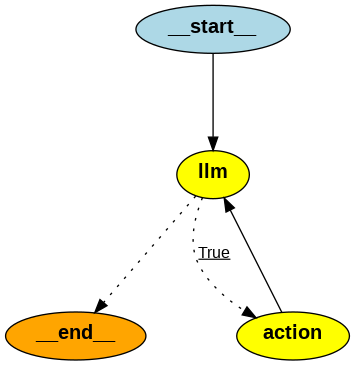

In [17]:
Image(abot.graph.get_graph().draw_png())